In [1]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import torchvision

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Preprocessing the image dataset. Might need to create a new one for additional dataset. 
class EmotionDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_mapping = {}

        current_label_id = 0
        for label in os.listdir(directory):
            label_path = os.path.join(directory, label)
            if os.path.isdir(label_path):
                if label not in self.label_mapping:
                    self.label_mapping[label] = current_label_id
                    current_label_id += 1

                for img in os.listdir(label_path):
                    img_path = os.path.join(label_path, img)
                    self.images.append(img_path)
                    self.labels.append(self.label_mapping[label])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)

        return image, label

In [3]:
# Create dataloaders for train, val and test
data_path = os.path.join(os.getcwd(), 'archive')
filepath_train = os.path.join(data_path, 'train')
filepath_test = os.path.join(data_path, 'test')
# transforms = None

transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = EmotionDataset(filepath_train, transform=transforms)
test_dataset = EmotionDataset(filepath_test, transform=transforms)

validation_split = 0.2 
train_sample = int(len(train_dataset) * (1 - validation_split))
val_samples = len(train_dataset) - train_sample
train_dataset, val_dataset = random_split(train_dataset, [train_sample, val_samples], generator=torch.Generator().manual_seed(21))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# The normalization method for ImageNet may not be suitable. Normalizing the dataset according to its own mean and std. 
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std

transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
train_dataset = EmotionDataset(filepath_train, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
mean, std = get_mean_std(train_loader)

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.5079, 0.5079, 0.5079])
Std: tensor([0.2502, 0.2502, 0.2502])


In [6]:
train_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(15), 
    T.ColorJitter(brightness=0.3, contrast=0.3), 
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)  
])

t_transforms = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


train_dataset = EmotionDataset(filepath_train, transform=train_transforms)
val_dataset = EmotionDataset(filepath_train, transform=t_transforms) 
test_dataset = EmotionDataset(filepath_test, transform=t_transforms)

total_size = len(train_dataset)
train_size = int(total_size * (1 - validation_split))
val_size = total_size - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(123))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

A slightly simplified version of the ResNet implementation found here: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

In [9]:
class ResBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = 1

    def forward(self, x):
        res = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            res = self.downsample(x)
        out += res
        out = self.relu(out)
        return out

In [10]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=7):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AvgPool2d(2, 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
        
    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

C:\Users\irela\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/20, Loss: 1.8245, Train Acc: 25.36%, Val Acc: 29.00%
Epoch 2/20, Loss: 1.6129, Train Acc: 37.13%, Val Acc: 36.19%
Epoch 3/20, Loss: 1.4006, Train Acc: 46.51%, Val Acc: 45.99%
Epoch 4/20, Loss: 1.2839, Train Acc: 50.82%, Val Acc: 48.69%
Epoch 5/20, Loss: 1.2229, Train Acc: 53.19%, Val Acc: 53.20%
Epoch 6/20, Loss: 1.1724, Train Acc: 55.60%, Val Acc: 53.10%
Epoch 7/20, Loss: 1.1375, Train Acc: 56.84%, Val Acc: 56.01%
Epoch 8/20, Loss: 1.1140, Train Acc: 57.77%, Val Acc: 56.55%
Epoch 9/20, Loss: 1.0833, Train Acc: 58.80%, Val Acc: 54.70%
Epoch 10/20, Loss: 1.0571, Train Acc: 60.13%, Val Acc: 57.65%
Epoch 11/20, Loss: 1.0327, Train Acc: 60.74%, Val Acc: 58.38%
Epoch 12/20, Loss: 1.0106, Train Acc: 61.52%, Val Acc: 58.08%
Epoch 13/20, Loss: 0.9874, Train Acc: 62.24%, Val Acc: 60.61%
Epoch 14/20, Loss: 0.9658, Train Acc: 63.63%, Val Acc: 59.44%
Epoch 15/20, Loss: 0.9505, Train Acc: 63.85%, Val Acc: 60.08%
Epoch 16/20, Loss: 0.9234, Train Acc: 64.93%, Val Acc: 60.85%
Epoch 17/20, Loss

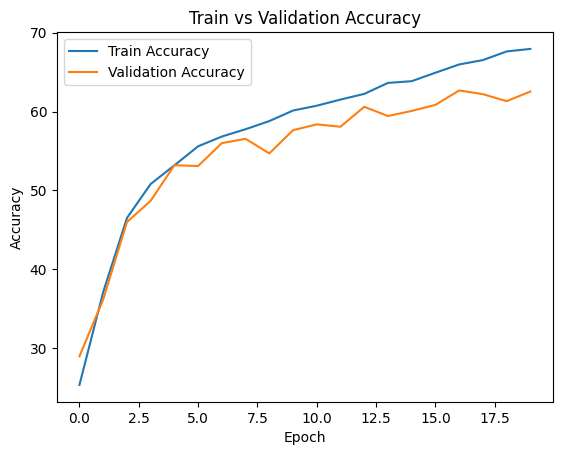

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(ResBlock, [3, 4, 6, 3])
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=10, verbose=True)

criterion = nn.CrossEntropyLoss()

train_acc = []
val_acc= []

num_epoch = 20 # Lowered for ResNet
best_val_accuracy = 0
patience = 20 # Num of epoch of no improvement in val_acc

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = torch.argmax(output, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_acc.append(val_accuracy)
    
    scheduler.step(val_accuracy)

    # Early stopping logic
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), 'resnetfix.pth')
        early_stopping_counter = 0  
    else:
        early_stopping_counter += 1
        
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {running_loss/len(train_dataloader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
    
    if early_stopping_counter > patience:
        print("Early stopping triggered after epoch {0}".format(epoch+1))
        break

print("Training completed. Best Validation Accuracy: {:.2f}%".format(best_val_accuracy))

# Plotting train and Validation accuracies
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

In [13]:
model = ResNet(ResBlock, [3, 4, 6, 3])
model.load_state_dict(torch.load('resnetfix.pth'))

model.eval()
model.to(device)
errors = []

correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 56.92%
